In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.manifold import TSNE
from pandas.tools.plotting import andrews_curves
import os
from pandas.tools.plotting import parallel_coordinates
from pandas.tools.plotting import radviz
import scipy

In [2]:
#Modelling
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
#import lightgbm as lgb
import warnings

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [3]:
os.chdir('/home/py/data/BANKING/')

In [4]:
os.listdir(".")

['bank_imp.csv', 'bank_final.csv']

In [5]:
df = pd.read_csv('bank_final.csv')

In [6]:
df.head(5)

,YEAR,DIV,ROE,ROC,NPM,DEP,Beta,P.B,P.E,EBVIDTA
0,1865,17.86,20.68,14.24,12.71,439.7,1.11,0.88,5.42,0.01
1,1865,16.04,24.57,14.52,13.34,479.6,1.08,0.79,3.51,0.01
2,1865,20.37,21.40,11.54,11.31,580.2,1.04,1.08,5.48,0.30
3,1865,20.08,22.01,11.26,11.41,619.4,1.06,1.44,7.72,0.67
4,1865,16.07,22.99,11.57,10.94,692.6,1.06,0.97,5.40,0.51


In [7]:
#del df['Company.Name']
del df['P.B']
del df['EBVIDTA']

In [8]:
df.shape

(367, 8)

# Feature Engineering

In [9]:
df["YEAR"] = df["YEAR"].astype("category")

In [10]:
# put ages in categories and add as columns to DataFrame
age_bins = [0, 1960, 1970, 1980, 1990,2000,2017]
age_labels = ["1", "2", "3", "4","5","6"]
df['YEAR'] = pd.cut(df['YEAR'], age_bins, labels=age_labels,right=True, include_lowest=True)

In [11]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

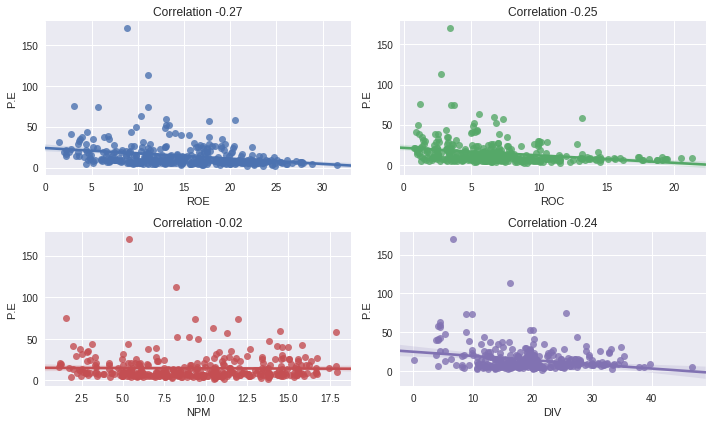

In [12]:
feats = ['ROE', 'ROC', 'NPM', 'DIV', 'DEP','Beta']

multiplot(data = df,features = feats,plottype = "regplot",nrows = 2, ncols = 2,
          figsize = (10,6),y = 'P.E', colorize = True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



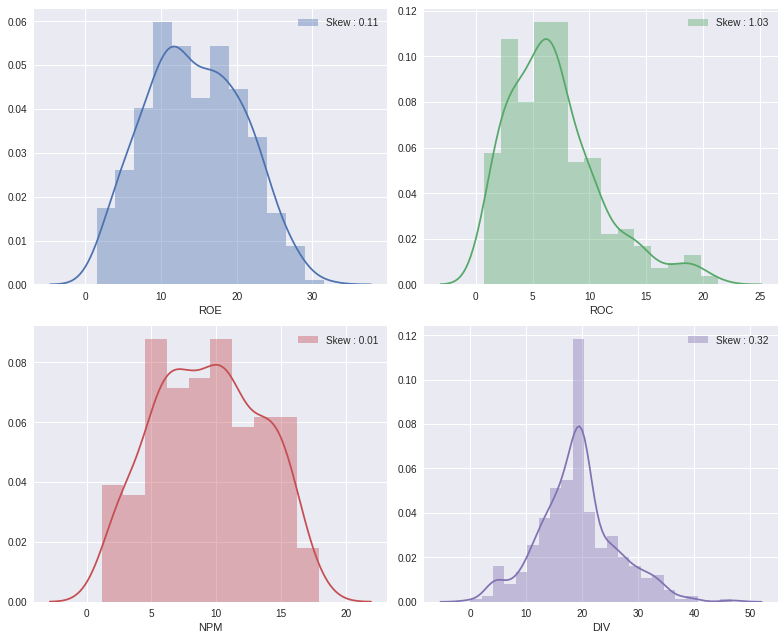

In [13]:
skewed_features = ['ROE', 'ROC', 'NPM', 'DIV', 'DEP','Beta']
multiplot(data = df,features = skewed_features,plottype = "distplot",
          nrows = 2, ncols = 2, figsize = (11,9), colorize = True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



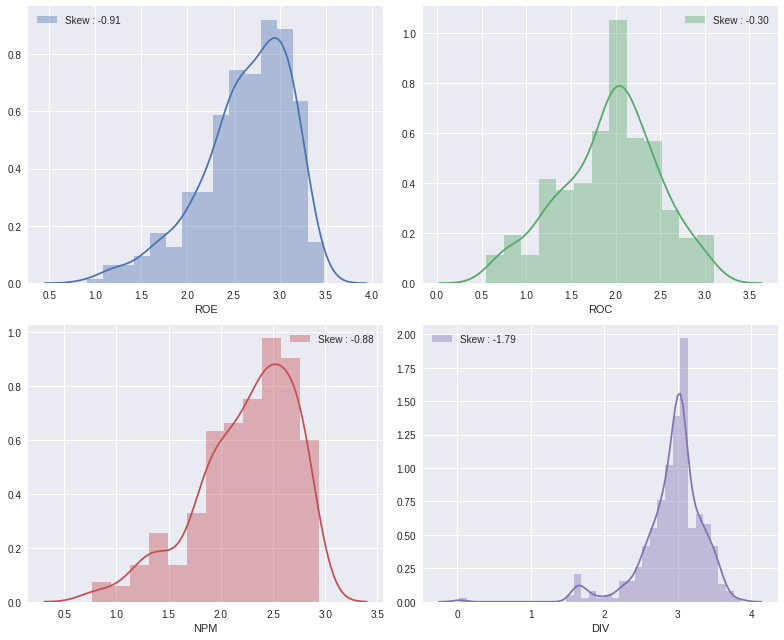

In [14]:
for feature in skewed_features:
    df[feature] = np.log1p(df[feature])
multiplot(data = df,features = skewed_features,plottype = "distplot",
          nrows = 2, ncols = 2, figsize = (11,9), colorize = True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



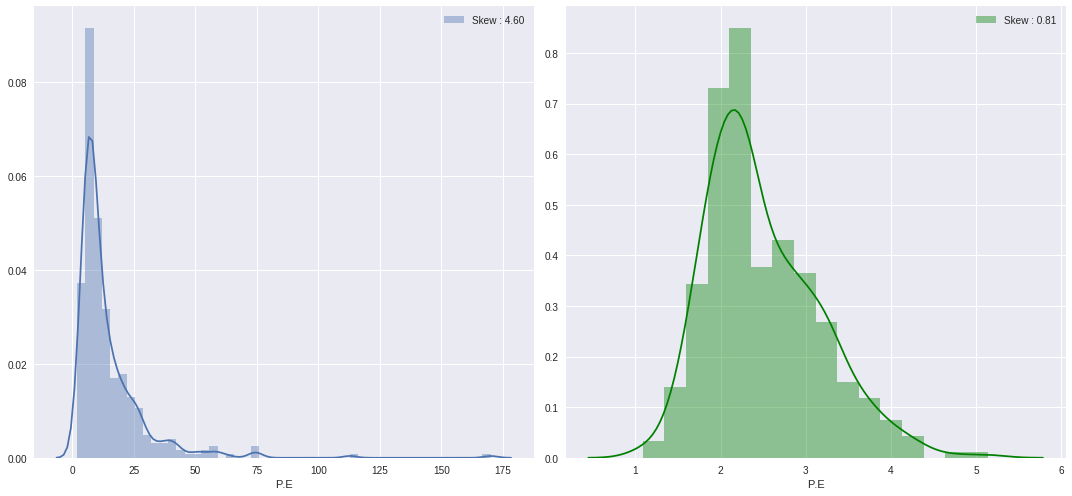

In [15]:
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.distplot(df['P.E'],ax = axes[0])
sns.distplot(np.log1p(df['P.E']),ax = axes[1],color="g")

axes[0].legend(["Skew : {:.2f}".format(df['P.E'].skew())])
axes[1].legend(["Skew : {:.2f}".format(np.log1p(df['P.E']).skew())])

plt.tight_layout()
plt.show()
plt.gcf().clear()

In [16]:
t = df.iloc[:,1:7]

In [17]:
z= df.filter(['YEAR','P.E'], axis=1)

In [18]:
list_ib = t.columns.values

for i in list_ib:
    for j in list_ib:
        if i == j:
            break
        else:
            new = t[i] * t[j]
            t['new_' + str(i) + '_' + str(j)] = new # Add new column which is the result of multiplying columns i and j together

In [19]:
df = pd.concat([t, z], axis = 1)

In [20]:
# Convert year to category
df['Age_1'] = df['YEAR'].map(lambda s: 1 if s == '1' else 0)
df['Age_2'] = df['YEAR'].map(lambda s: 1 if s == '2' else 0)
df['Age_3'] = df['YEAR'].map(lambda s: 1 if s == '3' else 0)
df['Age_4'] = df['YEAR'].map(lambda s: 1 if s == '4' else 0)
df['Age_5'] = df['YEAR'].map(lambda s: 1 if s == '5' else 0)
df['Age_6'] = df['YEAR'].map(lambda s: 1 if s == '6'  else 0)

In [21]:
df.tail(5)

,DIV,ROE,ROC,NPM,DEP,Beta,new_ROE_DIV,new_ROC_DIV,new_ROC_ROE,new_NPM_DIV,...,new_Beta_NPM,new_Beta_DEP,YEAR,P.E,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
362,2.737609,3.182212,2.037317,2.684440,6.014204,0.900161,8.711652,5.577376,6.483173,7.348948,...,2.416429,5.413754,6,14.26,0,0,0,0,0,1
363,2.867899,3.248823,1.902108,2.676215,6.250168,0.936093,9.317296,5.455052,6.179610,7.675115,...,2.505188,5.850741,6,12.68,0,0,0,0,0,1
364,2.938103,3.259250,1.927164,2.695978,6.449996,0.966984,9.576012,5.662207,6.281109,7.921060,...,2.606967,6.237042,6,9.22,0,0,0,0,0,1
365,2.983660,3.105931,1.953028,2.746630,6.746882,1.043804,9.267041,5.827170,6.065969,8.195008,...,2.866943,7.042423,6,17.01,0,0,0,0,0,1
366,2.866193,3.040706,1.958685,2.809403,7.008957,0.996949,8.715249,5.613970,5.955786,8.052290,...,2.800830,6.987570,6,14.33,0,0,0,0,0,1


# Explanotary Data Analysis

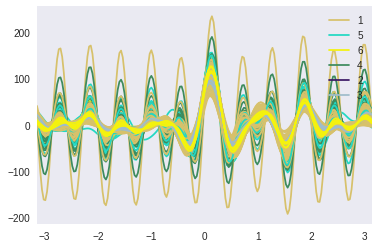

In [22]:
andrews_curves(df, 'YEAR')
plt.show()

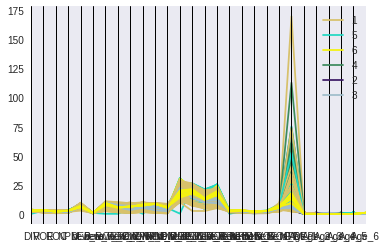

In [23]:
parallel_coordinates(df, 'YEAR')

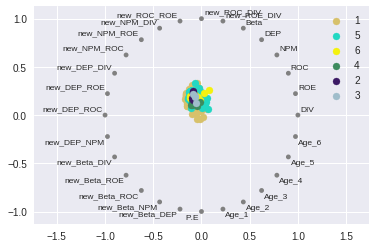

In [24]:
radviz(df, 'YEAR')

In [25]:
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=300,
    verbose=2,
    angle=0.5
)

In [26]:
tsne_results = tsne.fit_transform(df.iloc[:, 1:], df.iloc[:, 0:])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 367 / 367
[t-SNE] Mean sigma: 3.678579
[t-SNE] Iteration 25: error = 0.9721813, gradient norm = 0.0151019
[t-SNE] Iteration 50: error = 0.7269299, gradient norm = 0.0016070
[t-SNE] Iteration 75: error = 0.4333805, gradient norm = 0.0012696
[t-SNE] Iteration 100: error = 0.3373277, gradient norm = 0.0009568
[t-SNE] Iteration 100: gradient norm 0.000957. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.337328
[t-SNE] Iteration 125: error = 0.2068242, gradient norm = 0.0008046
[t-SNE] Iteration 125: gradient norm 0.000805. Finished.
[t-SNE] Error after 125 iterations: 0.337328


In [27]:
trace1 = go.Scatter3d(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    z=tsne_results[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = df['P.E'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'YEAR'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='Data')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [28]:
df.drop(labels=["YEAR"],axis = 1,inplace=True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



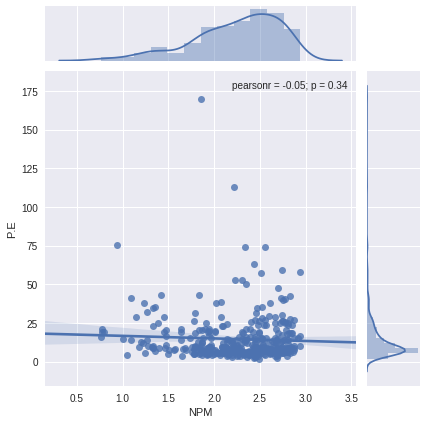

In [29]:
g = sns.jointplot(x = df['NPM'], y = df['P.E'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



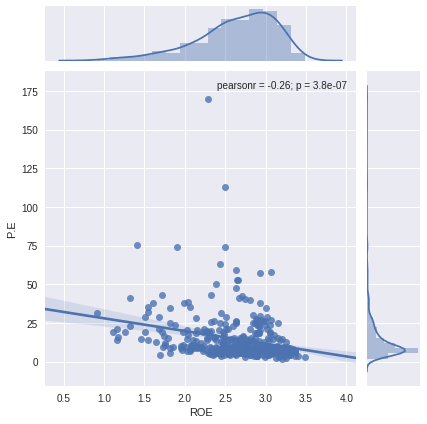

In [30]:
g = sns.jointplot(x = df['ROE'], y = df['P.E'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



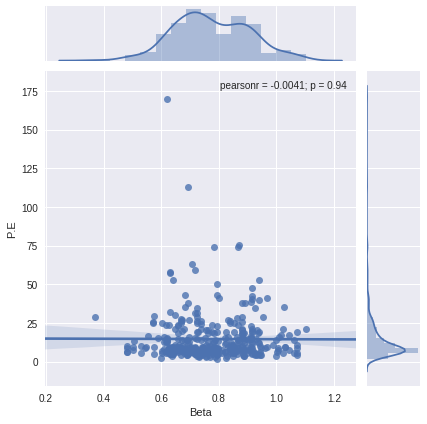

In [31]:
g = sns.jointplot(x = df['Beta'], y = df['P.E'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



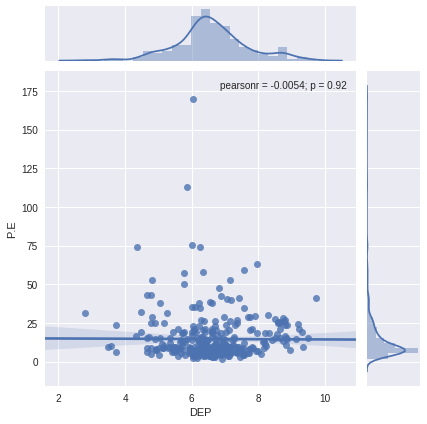

In [32]:
g = sns.jointplot(x = df['DEP'], y = df['P.E'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



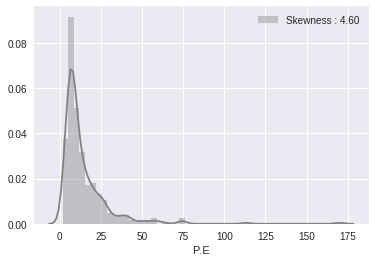

In [33]:
g = sns.distplot(df['P.E'],color="gray")
g = g.legend(['Skewness : {:.2f}'.format(df['P.E'].skew())],loc='best')

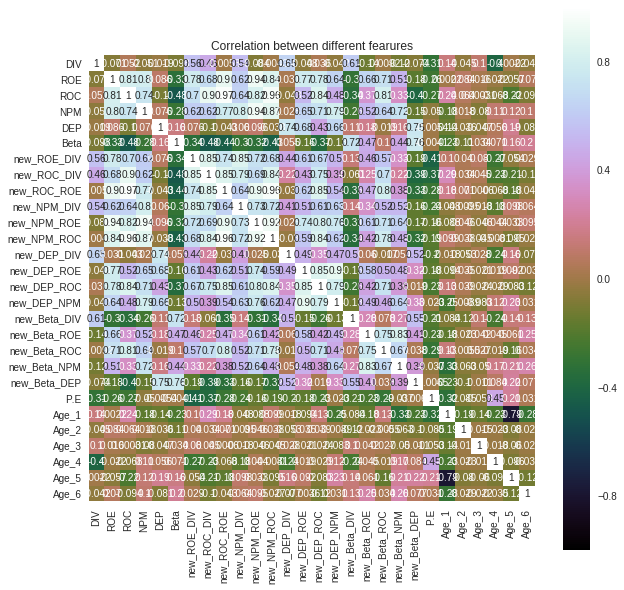

In [34]:
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')

# Transformation

In [35]:
df['P.E'] = np.log1p(df['P.E'])
Y = df['P.E']
df = df.drop(labels='P.E',axis = 1)

In [36]:
features = df.columns

In [37]:
# Normalize data 
#N = Normalizer()
N = RobustScaler()

N.fit(df)

df = N.transform(df)

In [38]:
train_len = len(df)

In [39]:
## Separate train dataset 
X_train = df[:train_len]

In [40]:
###### Train classifiers
Y_train = Y[:train_len]

In [44]:
lassocv = LassoCV(eps=1e-7) 
ridge = Ridge(alpha=0.05) 
lassolarscv = LassoLarsCV()
elasticnetcv = ElasticNetCV(eps=1e-15)

# 6.1.1 Cross validate models

In [45]:
# Regression linear models (Lasso, Ridge, Elasticnet)
def RMSE(estimator,X_train, Y_train, cv=5,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [46]:
RMSE(lassocv, X_train, Y_train)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data w

0.51623996854146559

In [47]:
RMSE(ridge, X_train, Y_train)

0.52584810660671721

In [48]:
RMSE(lassolarscv, X_train, Y_train)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, alpha=4.191e-03, previous alpha=1.072e-04, with an active set of 16 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=3.068e-03, previous alpha=8.749e-05, with an active set of 19 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=1.067e-03, previous alpha=1.090e-04, with an active set of 20 regressors.

/home/py/anaconda3/lib/python3.6/s

0.51103534191773481

In [49]:
RMSE(elasticnetcv, X_train, Y_train)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data w

0.51656724019420852

In [50]:
lassocv.fit(X_train,Y_train)
ridge.fit(X_train,Y_train)
lassolarscv.fit(X_train,Y_train)
elasticnetcv.fit(X_train,Y_train)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=2.342e-04, previous alpha=1.223e-04, with an active set of 18 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=5.310e-03, previous alpha=9.195e-06, with an active set of 23 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: Conve

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=1e-15, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

# Features coefficients

In [51]:
print("LassoCV regression has conserved %d features over %d"%(len(features[lassocv.coef_!=0]),X_train.shape[1]))
print("Ridge regression has conserved %d features over %d"%(len(features[ridge.coef_!=0]),X_train.shape[1]))
print("LassoLarsCV regression has conserved %d features over %d"%(len(features[lassolarscv.coef_!=0]) ,X_train.shape[1]))
print("ElasticNetCV regression has conserved %d features over %d"%(len(features[elasticnetcv.coef_!=0]),X_train.shape[1]))

LassoCV regression has conserved 16 features over 27
Ridge regression has conserved 27 features over 27
LassoLarsCV regression has conserved 15 features over 27
ElasticNetCV regression has conserved 17 features over 27


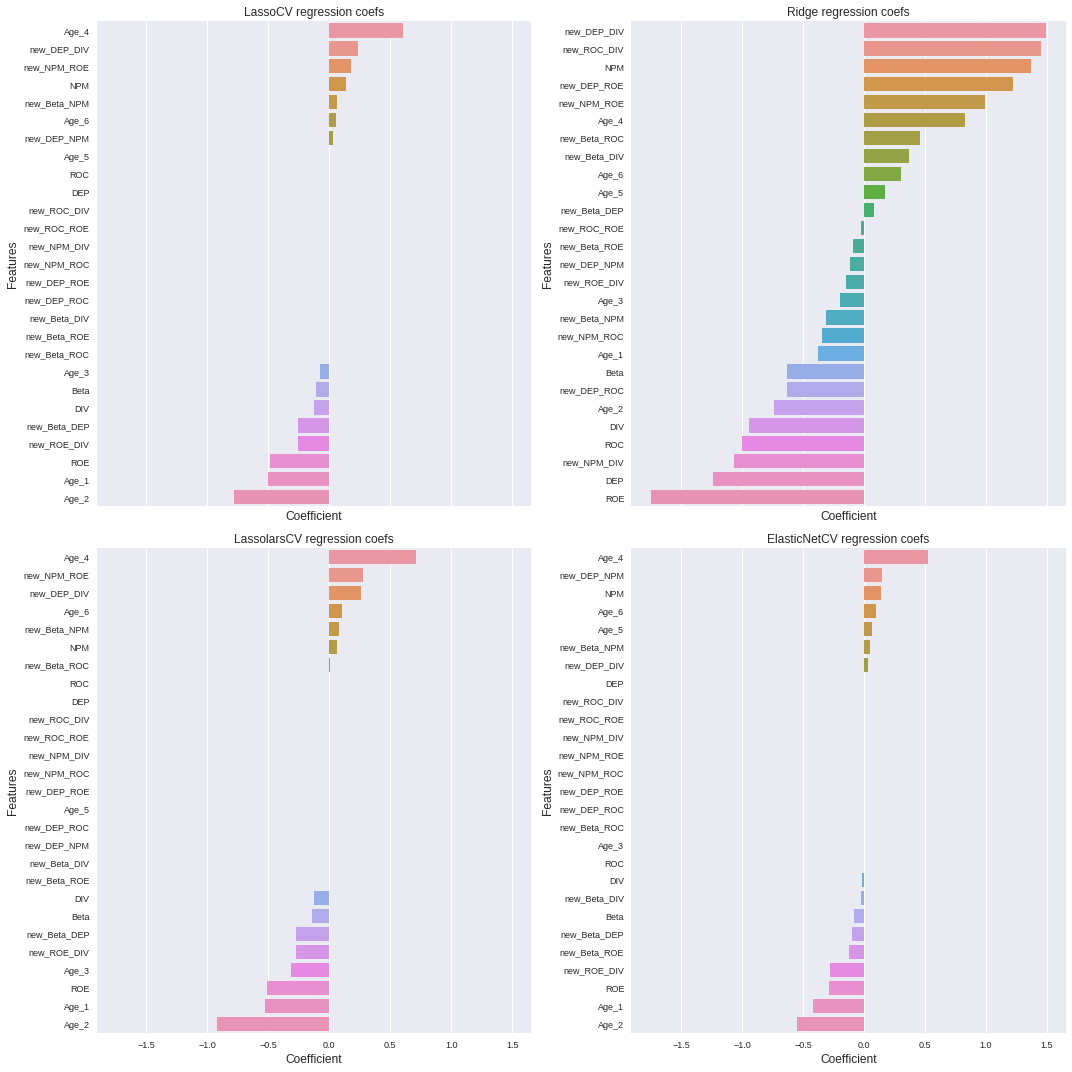

In [52]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_regressors = [("LassoCV", lassocv),("Ridge",ridge),("LassolarsCV",lassolarscv),("ElasticNetCV",elasticnetcv)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.coef_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.coef_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Coefficient",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " regression coefs")
        nregressors += 1
plt.tight_layout()
plt.show()
plt.gcf().clear()

In [53]:
Y_pred_lassocv = np.expm1(lassocv.predict(X_train))
Y_pred_lassolarscv = np.expm1(lassolarscv.predict(X_train))
Y_pred_elasticnetcv = np.expm1(elasticnetcv.predict(X_train))

# Tree based modeling

In [54]:
# XGBoost

#model_xgb = xgb.XGBRegressor(n_estimators=3000, max_depth=2, learning_rate=0.1)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)

RMSE(model_xgb,X_train,Y_train)

0.52626948683849939

In [55]:
model_xgb.fit(X_train,Y_train)
Y_pred_xgb = np.expm1(model_xgb.predict(X_train))

In [56]:
# Gradient Boosting
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
RMSE(GBoost,X_train,Y_train)

0.51829398724921749

In [57]:
GBoost.fit(X_train,Y_train)
Y_pred_GBoost = np.expm1(GBoost.predict(X_train))

In [63]:
# Light GBM
LightGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

RMSE(LightGB,X_train,Y_train)

NameError: name 'lgb' is not defined

In [257]:
LightGB.fit(X_train,Y_train)
Y_pred_LightGB = np.expm1(LightGB.predict(X_train))

# Features importance

NameError: name 'LightGB' is not defined

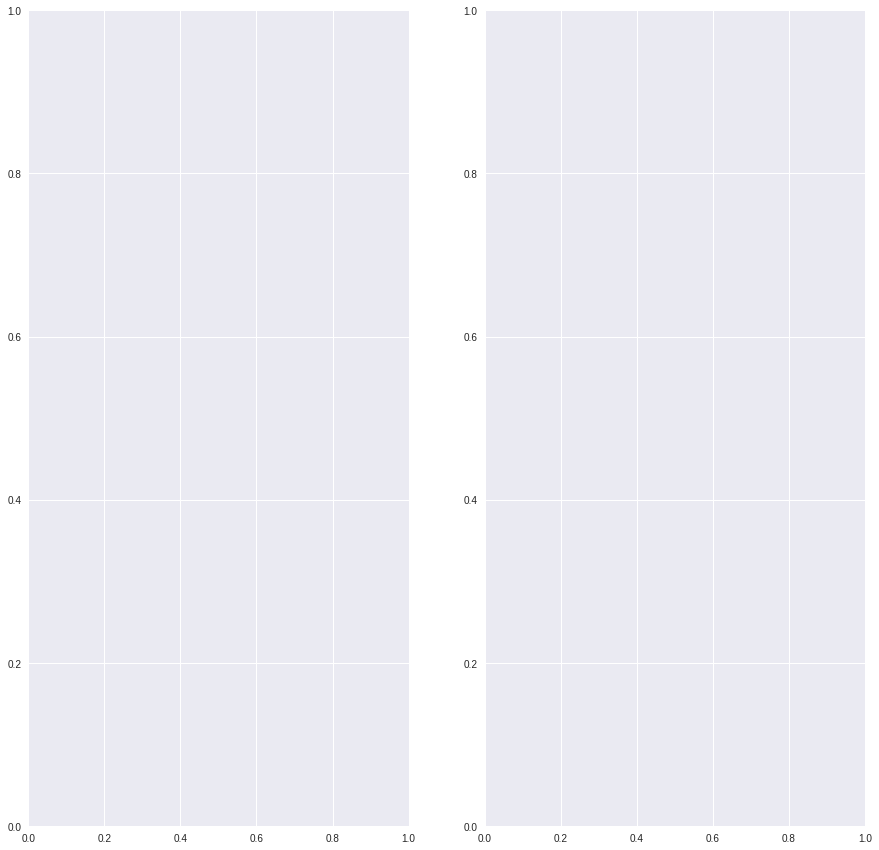

In [120]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15,15))

names_regressors = [("LightGBM",LightGB),("GBoosting",GBoost)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.feature_importances_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.feature_importances_[indices][:40] , orient='h',ax=axes[nregressors])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nregressors += 1

plt.tight_layout()
plt.show()
plt.gcf().clear()

# Learning Rate

In [ ]:
def plot_learning_curves(estimators, titles, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 4)):
    """Generate a simple plot of the test and training learning curve"""
    nrows = len(estimators)//2
    ncols = (len(estimators)//nrows)+ (0 if len(estimators) % nrows == 0 else 1)
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    
    n = 0
    for col in range(ncols):
        for row in range(nrows):
            estimator = estimators[n]
            title = titles[n]
            axes[row,col].set_title(title)
            
            if ylim is not None:
                axes[row,col].set_ylim(*ylim)
            
            axes[row,col].set_xlabel("Training examples")
            axes[row,col].set_ylabel("Score")
            
            train_sizes, train_scores, test_scores = learning_curve(estimator,
                    X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
                    scoring="neg_mean_squared_error")
    
            train_scores = np.sqrt(-train_scores)
            test_scores = np.sqrt(-test_scores)
    
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)
            axes[row,col].grid()
        
            axes[row,col].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.5,
                     color="r")
            axes[row,col].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.5, color="g")
            axes[row,col].plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
            axes[row,col].plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
            axes[row,col].legend(loc="best")
            
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

    

estimators = [lassocv,lassolarscv,elasticnetcv,GBoost,model_xgb]
titles = ["LassoCV","LassoLarsCV","ElasticNet","Gradient Boosting","Xgboost"]

plot_learning_curves(estimators, titles, X_train, Y_train, cv=3 ,n_jobs=5)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data w